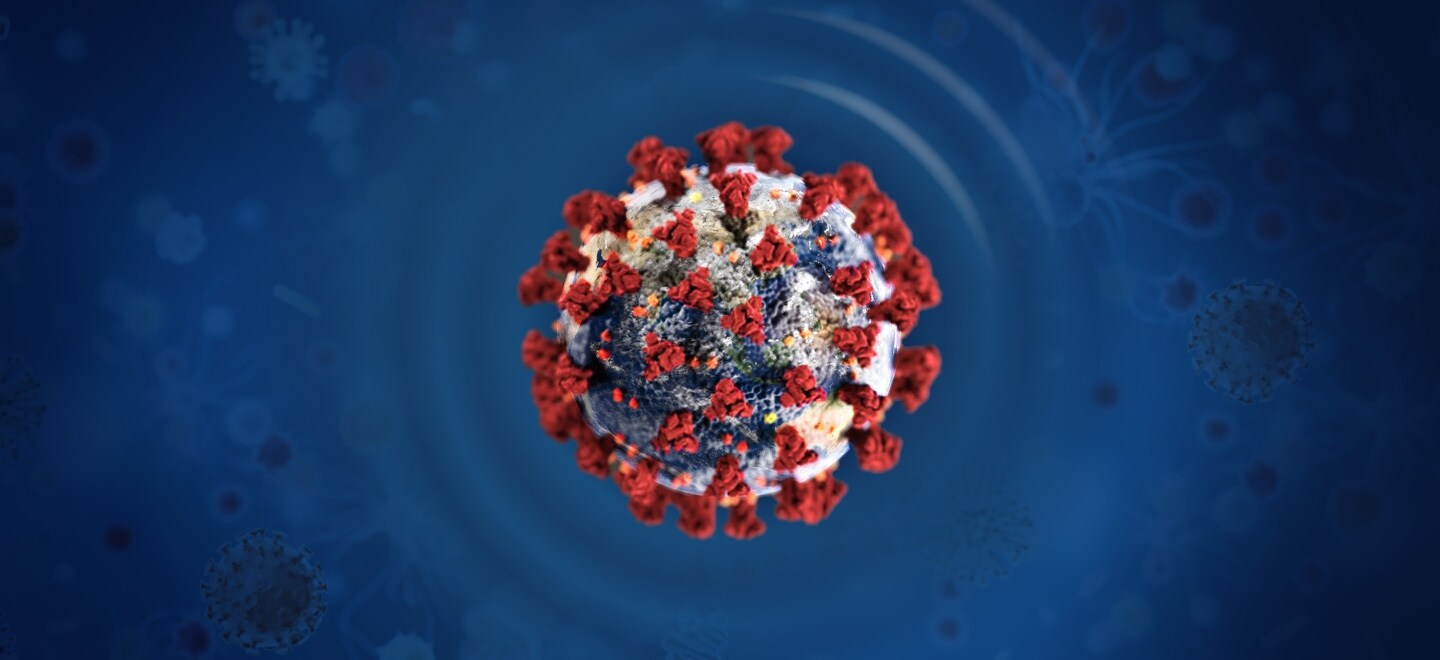
# COVID-19 GLOBAL FORECASTING CHALLANGE WEEK 2



**Introduction**

Two months ago, the World shook and within a day, every men and women knew of a looming threat named novel coronavirus. First occurrence in the Wuhan district, Hubei province of China, it quickly spread out to the rest of the world. Countries like Italy and US still are in dire situation. the number of corona victims is growing ia a huge rate dayby day.we found a time series data on the effect of COVID-19 from github. Our first target is to visualize the data.with this we can get an overview of what is going on due to COVID-19 around the world. Our next target is to fit some model for the given data. after that we will be able to predict the growth of the effect of COVID-19 for next few days. For all of our computations we are using python programming language


In [ ]:
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import cross_val_score, GridSearchCV,cross_val_predict
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error,  r2_score
import numpy as np
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"
import datetime

# Data Cleaning and Preprocessing

In [ ]:
mat.rcParams.update({'figure.figsize':(20,15),'font.size':14})
covid19_train = pd.read_csv('../input/covid19-global-forecasting-week-2/train.csv')
covid19_test = pd.read_csv('../input/covid19-global-forecasting-week-2/test.csv')
covid19_train.rename(columns={'Id':'ForecastId'},inplace=True)
data = pd.read_csv('../input/coviddata/time-series-19-covid-combined.csv')


In [ ]:
covid19_train['Date-All'] = covid19_train['Date'].str.replace('-','').astype(int)
covid19_test['Date-All'] = covid19_test['Date'].str.replace('-','').astype(int)
data['Date-All'] =data['Date'].str.replace('-','').astype(int)

covid19_train['Date'] = pd.to_datetime(covid19_train['Date'])
covid19_test['Date'] = pd.to_datetime(covid19_test['Date'])
data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
covid19_gdf = covid19_train.groupby(['Date','Country_Region'])['ConfirmedCases'].sum().reset_index()
covid19_gdf['date'] = pd.to_datetime(covid19_gdf['Date'])
covid19_gdf['date'] = covid19_gdf['date'].dt.strftime('%m/%d/%Y')


data_gdf = data.groupby(['Date','Country/Region'])['Confirmed'].sum().reset_index()
data_gdf['date'] = pd.to_datetime(data['Date'])
data_gdf['date'] = data_gdf['date'].dt.strftime('%m/%d/%Y')



In [ ]:
covid19_gdf

In [ ]:
conf=pd.read_csv("../input/coviddata/time_series_covid19_confirmed_global.csv")
death=pd.read_csv("../input/coviddata/time_series_covid19_deaths_global.csv")
recov=pd.read_csv("../input/coviddata/time_series_covid19_recovered_global.csv")
cum=pd.read_csv("../input/coviddata/time_series_covid19_cumudf_global.csv")
daily=pd.read_csv("../input/coviddata/time_series_covid19_dailydf_global.csv")
cols=conf.keys()
confirmed = conf.loc[:, cols[4]:cols[-1]]
deaths = death.loc[:, cols[4]:cols[-1]]
recoveries = recov.loc[:, cols[4]:cols[-1]]


# DATA VISUALIZATION

In [ ]:
fig = px.scatter_geo(covid19_gdf.fillna(0), locations="Country_Region", locationmode='country names', 
                     color="ConfirmedCases", size="ConfirmedCases", hover_name="Country_Region", 
                     projection="natural earth", animation_frame="date", 
                     title='COVID-19 Spread', color_continuous_scale="OrRd")
fig.update(layout_coloraxis_showscale=False)
fig.show()

In [ ]:
totalCountryCases = covid19_train.drop_duplicates(['Province_State', 'Country_Region'],keep='last').groupby(['Country_Region'])[['ConfirmedCases']].sum().sort_values('ConfirmedCases',ascending=False)
totalCountryCases.head(20).plot(kind='bar',color='r')
plt.xlabel("Country/Region")
plt.ylabel("Number of cases")
plt.grid()
plt.show()

In [ ]:
totalDailyCases = covid19_train.groupby(['Date'])[['ConfirmedCases']].sum().sort_values('ConfirmedCases',ascending=False)
totalDailyDeaths = covid19_train.groupby(['Date'])[['Fatalities']].sum().sort_values('Fatalities',ascending=False)


In [ ]:
totalDailyCases.plot(grid=False,marker='.',color='black',markersize=20)
plt.grid(color='r',linestyle='-')
totalDailyDeaths.plot(grid=False,marker='.',color='r',markersize=20)
plt.grid(color='r',linestyle='-')
plt.show()


In [ ]:
col=cum.keys()
c=cum.loc[:,col[1]]
d=cum.loc[:,col[2]]
r=cum.loc[:,col[3]]
#make date column
start="01/22/2020"
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
date=[]
for i in range(len(cum["Days"])):
    date.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

#PLot
plt.figure
plt.plot(cum['Days'],c,'b',label="Confirmed Cases",marker='.',markersize='15')
plt.plot(cum['Days'],d,'r',label="Deaths",marker='.',markersize='10')
plt.plot(cum['Days'],r,'g',label="Recovery",marker='.',markersize='12')
plt.grid()
plt.legend()

plt.show()


In [ ]:
##case studies
china_cases = [] 
italy_cases = []
us_cases = [] 
spain_cases = [] 
india_cases=[]
days=cum['Days']
n=confirmed.keys()


In [ ]:
for i in n:
    china_cases.append(conf[conf['Country/Region']=='China'][i].sum())
    italy_cases.append(conf[conf['Country/Region']=='Italy'][i].sum())
    us_cases.append(conf[conf['Country/Region']=='US'][i].sum())
    spain_cases.append(conf[conf['Country/Region']=='Spain'][i].sum())
    india_cases.append(conf[conf["Country/Region"]=='India'][i].sum())


In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(days, china_cases,'r',label="China")
plt.plot(days, italy_cases,'g',label="Italy")
plt.plot(days, us_cases,'b',label="US")
plt.plot(days, spain_cases,'y',label="Spain")
plt.title(' Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Confirmed Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend()
plt.show()

In [ ]:
#Death cases

china_death=[]
us_death=[]
spain_death=[]
italy_death=[]
india_death=[]

for i in n:
    china_death.append(death[death['Country/Region']=='China'][i].sum())
    italy_death.append(death[death['Country/Region']=='Italy'][i].sum())
    us_death.append(death[death['Country/Region']=='US'][i].sum())
    spain_death.append(death[death['Country/Region']=='Spain'][i].sum())
    india_death.append(death[death["Country/Region"]=='India'][i].sum())


**Visialization of Death cases in China, US, Spain,Italy and India**

In [ ]:
plt.figure()
plt.plot(days,china_death,'r',label="Death cases in China")
plt.plot(days,italy_death,'b',label="Death cases in Italy")
plt.plot(days,spain_death,'y',label="Death cases in Spain")
plt.plot(days,us_death,'g',label="Death cases in US")
plt.grid()
plt.xlabel("Days")
plt.ylabel("Death Cases")
plt.legend()

plt.show()

In [ ]:

china_cases=np.array(china_cases).reshape(1,-1)
italy_cases=np.array(italy_cases).reshape(1,-1)
spain_cases=np.array(spain_cases).reshape(1,-1)
india_cases=np.array(india_cases).reshape(1,-1)
us_cases=np.array(us_cases).reshape(1,-1)


In [ ]:
#Mortality Rates
mort_china=china_death/china_cases
mort_italy=italy_death/italy_cases
mort_spain=spain_death/spain_cases
mort_india=india_death/india_cases
mort_us=us_death/us_cases

In [ ]:
#Visualization of Mortality Rates
plt.figure()
plt.plot(days,mort_china.transpose(),'r',label="Mortality of China")
plt.plot(days,mort_italy.transpose(),'b',label="Mortality of Italy")
plt.plot(days,mort_spain.transpose(),'y',label="Mortality of Spain")
plt.plot(days,mort_us.transpose(),'black',label="Mortality of US")
plt.plot(days,mort_india.transpose(),'orange',label="Mortality of India")
plt.legend()
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Mortality', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.grid()
plt.show()

**INDIA**

# S-I-R MODEL 

**SIR MODEL:**
We have seen some general behavior of the virus in agregated data, for the country where the coronavirus was originated and for four other interesting countries. There's a lot of information to be extracted from this data; for example, we haven't analyzed the effects of long/lat of countries. However, since our main purpose is to develop a predective model in order to understand the key factors that impact the COVID-19 transmission, I'll move on to one of the most famous epidemiologic models: SIR.

SIR is a simple model that considers a population that belongs to one of the following states:

**Susceptible (S):** The individual hasn't contracted the disease, but she can be infected due to transmisison from infected people

**Infected (I):** This person has contracted the disease

**Recovered/Deceased (R)**: The disease may lead to one of two destinies: either the person survives, hence developing inmunity to the disease, or the person is deceased.
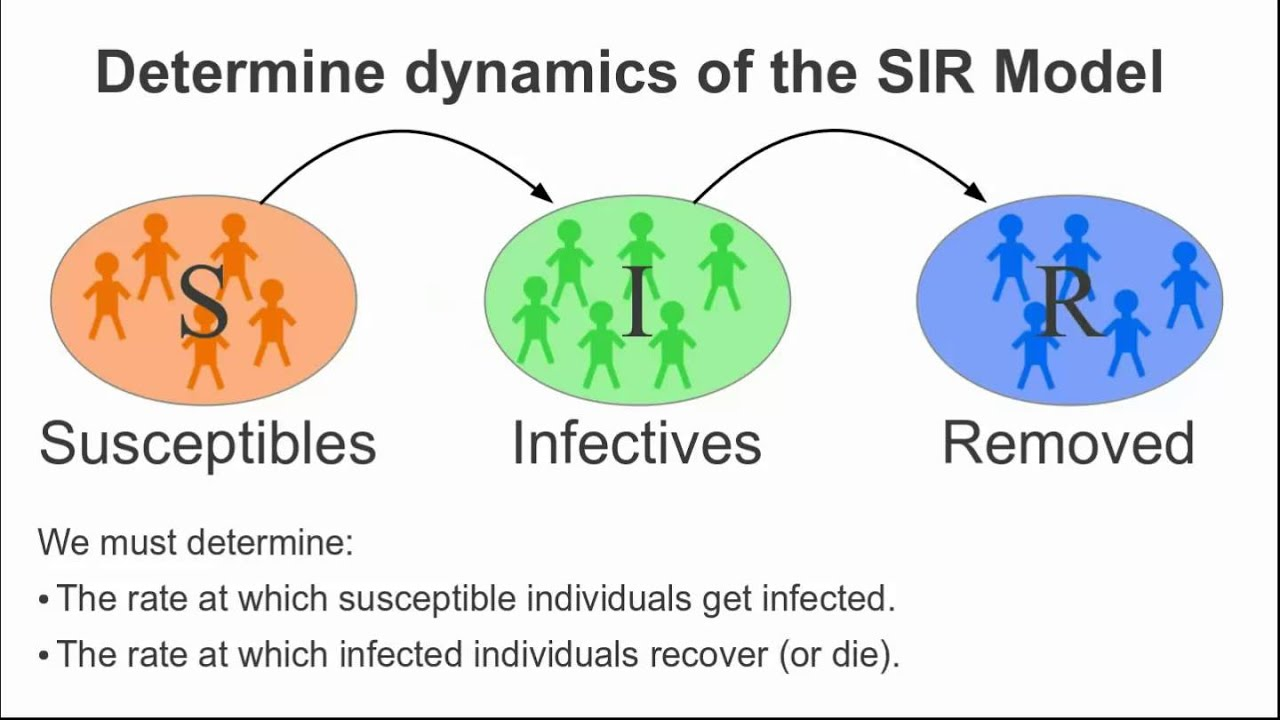

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, optimize

In [ ]:
def fa(N, a, b, beta):
    fa = -beta*a*b
    return fa

# Infected equation
def fb(N, a, b, beta, gamma):
    fb = beta*a*b - gamma*b
    return fb

# Recovered/deceased equation
def fc(N, b, gamma):
    fc = gamma*b
    return fc

In [ ]:
def rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs):
    a1 = fa(N, a, b, beta)*hs
    b1 = fb(N, a, b, beta, gamma)*hs
    c1 = fc(N, b, gamma)*hs
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    a2 = fa(N, ak, bk, beta)*hs
    b2 = fb(N, ak, bk, beta, gamma)*hs
    c2 = fc(N, bk, gamma)*hs
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    a3 = fa(N, ak, bk, beta)*hs
    b3 = fb(N, ak, bk, beta, gamma)*hs
    c3 = fc(N, bk, gamma)*hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(N, ak, bk, beta)*hs
    b4 = fb(N, ak, bk, beta, gamma)*hs
    c4 = fc(N, bk, gamma)*hs
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    return a, b, c


In [ ]:
def SIR(N, b0, beta, gamma, hs):
    
    """
    N = total number of population
    beta = transition rate S->I
    gamma = transition rate I->R
    k =  denotes the constant degree distribution of the network (average value for networks in which 
    the probability of finding a node with a different connectivity decays exponentially fast
    hs = jump step of the numerical integration
    """
    
    # Initial condition
    a = float(N-1)/N -b0
    b = float(1)/N +b0
    c = 0.

    sus, inf, rec= [],[],[]
    for i in range(10000): # Run for a certain number of time-steps
        sus.append(a)
        inf.append(b)
        rec.append(c)
        a,b,c = rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

    return sus, inf, rec


In [ ]:
"""Results obtained for N=world population, only one initial infected case, β=0.3
, γ=0.5 and a leap pass hs=0.1 are shown below:"""
    
#parameters of the model
N = 7800*(10**6)
b0 = 0
beta = 0.7
gamma = 0.2
hs = 0.1


In [ ]:
sus, inf, rec = SIR(N, b0, beta, gamma, hs)

In [ ]:
f = plt.figure(figsize=(8,5)) 
plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected');
plt.plot(rec, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,1000)
plt.savefig('SIR_example.png')
plt.show()

# S-I-R MODEL FOR INDIA

In [ ]:
#Implement the model on real life data
#Data preparation
import pandas as pd
data= pd.read_csv("../input/coviddata/time-series-19-covid-combined.csv")
confirmed_total_date = data.groupby(['Date']).agg({'Confirmed':['sum']})
fatalities_total_date = data.groupby(['Date']).agg({'Deaths':['sum']})
total_date = confirmed_total_date.join(fatalities_total_date)
#For india
confirmed_india = data[data['Country/Region']=='India'].groupby(['Date']).agg({'Confirmed':['sum']})
fatalities_india = data[data['Country/Region']=='India'].groupby(['Date']).agg({'Deaths':['sum']})
total_date_india = confirmed_india.join(fatalities_india)
pop_india=1380004385
population = float(pop_india)
country_df = total_date_india[9:]
country_df['day_count'] = list(range(1,len(country_df)+1))

ydata = [i for i in country_df.Confirmed['sum'].values]
xdata = country_df.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)

In [ ]:
N = population
inf0 = ydata[0]
sus0 = N - inf0
rec0 = 0.0

def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model to global infected cases")
plt.ylabel("Population infected in India")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

# FORECASTING 

In [ ]:
from scipy.optimize import curve_fit

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from random import random

In [ ]:
PATH_WEEK2='/kaggle/input/covid19-global-forecasting-week-2'
df_train = pd.read_csv(f'{PATH_WEEK2}/train.csv')
df_test = pd.read_csv(f'{PATH_WEEK2}/test.csv')
df_train.head()
df_test.head()
df_train.rename(columns={'Country_Region':'Country'}, inplace=True)
df_test.rename(columns={'Country_Region':'Country'}, inplace=True)

df_train.rename(columns={'Province_State':'State'}, inplace=True)
df_test.rename(columns={'Province_State':'State'}, inplace=True)

df_train['Date'] = pd.to_datetime(df_train['Date'], infer_datetime_format=True)
df_test['Date'] = pd.to_datetime(df_test['Date'], infer_datetime_format=True)

df_train.info()
df_test.info()

y1_Train = df_train.iloc[:, -2]
y1_Train.head()
y2_Train = df_train.iloc[:, -1]
y2_Train.head()

EMPTY_VAL = "EMPTY_VAL"

def fillState(state, country):
    if state == EMPTY_VAL: return country
    return state

In [ ]:
#X_Train = df_train.loc[:, ['State', 'Country', 'Date']]
X_Train = df_train.copy()

X_Train['State'].fillna(EMPTY_VAL, inplace=True)
X_Train['State'] = X_Train.loc[:, ['State', 'Country']].apply(lambda x : fillState(x['State'], x['Country']), axis=1)

X_Train.loc[:, 'Date'] = X_Train.Date.dt.strftime("%m%d")
X_Train["Date"]  = X_Train["Date"].astype(int)

X_Train.head()

#X_Test = df_test.loc[:, ['State', 'Country', 'Date']]
X_Test = df_test.copy()

X_Test['State'].fillna(EMPTY_VAL, inplace=True)
X_Test['State'] = X_Test.loc[:, ['State', 'Country']].apply(lambda x : fillState(x['State'], x['Country']), axis=1)

X_Test.loc[:, 'Date'] = X_Test.Date.dt.strftime("%m%d")
X_Test["Date"]  = X_Test["Date"].astype(int)

X_Test.head()


In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

X_Train.Country = le.fit_transform(X_Train.Country)
X_Train['State'] = le.fit_transform(X_Train['State'])

X_Train.head()

X_Test.Country = le.fit_transform(X_Test.Country)
X_Test['State'] = le.fit_transform(X_Test['State'])

X_Test.head()

df_train.head()
df_train.loc[df_train.Country == 'Afghanistan', :]
df_test.tail()


In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import preprocessing

le = preprocessing.LabelEncoder()

from xgboost import XGBRegressor

countries = X_Train.Country.unique()

#models_C = {}
#models_F = {}

df_out = pd.DataFrame({'ForecastId': [], 'ConfirmedCases': [], 'Fatalities': []})

for country in countries:
    states = X_Train.loc[X_Train.Country == country, :].State.unique()
    #print(country, states)
    # check whether string is nan or not
    for state in states:
        X_Train_CS = X_Train.loc[(X_Train.Country == country) & (X_Train.State == state), ['State', 'Country', 'Date', 'ConfirmedCases', 'Fatalities']]
        
        y1_Train_CS = X_Train_CS.loc[:, 'ConfirmedCases']
        y2_Train_CS = X_Train_CS.loc[:, 'Fatalities']
        
        X_Train_CS = X_Train_CS.loc[:, ['State', 'Country', 'Date']]
        
        X_Train_CS.Country = le.fit_transform(X_Train_CS.Country)
        X_Train_CS['State'] = le.fit_transform(X_Train_CS['State'])
        
        X_Test_CS = X_Test.loc[(X_Test.Country == country) & (X_Test.State == state), ['State', 'Country', 'Date', 'ForecastId']]
        
        X_Test_CS_Id = X_Test_CS.loc[:, 'ForecastId']
        X_Test_CS = X_Test_CS.loc[:, ['State', 'Country', 'Date']]
        
        X_Test_CS.Country = le.fit_transform(X_Test_CS.Country)
        X_Test_CS['State'] = le.fit_transform(X_Test_CS['State'])
        
        #models_C[country] = gridSearchCV(model, X_Train_CS, y1_Train_CS, param_grid, 10, 'neg_mean_squared_error')
        #models_F[country] = gridSearchCV(model, X_Train_CS, y2_Train_CS, param_grid, 10, 'neg_mean_squared_error')
        
        model1 = XGBRegressor(n_estimators=1000)
        model1.fit(X_Train_CS, y1_Train_CS)
        y1_pred = model1.predict(X_Test_CS)
        
        model2 = XGBRegressor(n_estimators=1000)
        model2.fit(X_Train_CS, y2_Train_CS)
        y2_pred = model2.predict(X_Test_CS)
        
        df = pd.DataFrame({'ForecastId': X_Test_CS_Id, 'ConfirmedCases': y1_pred, 'Fatalities': y2_pred})
        df_out = pd.concat([df_out, df], axis=0)
    # Done for state loop
# Done for country Loop

In [ ]:
df_out.ForecastId = df_out.ForecastId.astype('int')
df_out.tail()
df_out.to_csv('submission.csv', index=False)

**THANK YOU!!**